### First, detect the faces and eyes in an image.  
Then calculate the contrast of the face and eyes to determine if the eyes are in focus.
The face detection algorithm in opencv, the haar cascade, gives too many false positives.  Instead we are going to rewrite the script to use dlib's histogram of gradients (HOG) detector.  

We are going to follow dlib's public domain example algorithm to detect faces in the image.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import cv2
import numpy as np
import time
import dlib

Import the image and load grayscale version of it

In [323]:
img = cv2.imread('imgs/20160306_IMG_2790p.JPG')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
imgmp =  cv2.cvtColor(img, cv2.cv.CV_BGR2RGB) #this is to plot images using matplotlib

In [324]:
detector = dlib.get_frontal_face_detector()
predictor_path =  'facepredictor/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)

In [325]:
t1 = time.time()
#detect faces

faces = detector(gray)
if(len(faces) == 0 ):
    #did not detect faces. This is slightly slower
    print "Try color expanded"
    faces = detector(imgmp,1)
if(len(faces) == 0 ):
    #now try rotation
    print "Try Rotation"
    NN = 5
    rows,cols = gray.shape
    for j,i in enumerate(linspace(360./NN,360*(NN-1)*1./NN,NN)):
        M = cv2.getRotationMatrix2D((cols/2,rows/2),i,1)
        dst = cv2.warpAffine(img,M,(cols,rows))
        faces = detector(dst)
        if(len(faces)>0):
            img = dst
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            imgmp =  cv2.cvtColor(img, cv2.cv.CV_BGR2RGB) #this is to plot images using matplotlib
            break
#this could be sped up by rescaling large images
t2 = time.time()
print "It took ", t2-t1, "seconds to complete faces."
fshapes = []
print "Found ", len(faces), " face(s)."
for k, d in enumerate(faces):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
        # Get the landmarks/parts for the face in box d.
        shape = predictor(gray, d)
        fshapes.append(shape)
        print("Part 0: {}, Part 1: {} ...".format(shape.part(0),
                                                  shape.part(1)))
        # Draw the face landmarks on the screen.
t3 = time.time()
print "It took ", t3-t2, "seconds to find 68 point features."

It took  2.13096094131 seconds to complete faces.
Found  1  face(s).
Detection 0: Left: 2139 Top: 1107 Right: 2397 Bottom: 1365
Part 0: (2131, 1197), Part 1: (2143, 1233) ...
It took  0.00609111785889 seconds to find 68 point features.


In [326]:
#find largest face
areas = zeros(len(faces))
for i, f in enumerate(faces):
    areas[i] = f.area()
index = (areas).argmax()
shape = fshapes[index]

In [327]:
sqrt(areas)

array([ 259.])

In [328]:
def get_right_eye(shape):
    xpts = []
    ypts = []
    
    for i in arange(36,42):
        xpts.append(shape.part(i).x)
        ypts.append(shape.part(i).y)
    xpts = array(xpts)
    ypts = array(ypts)
    dx = xpts.max() - xpts.min()
    dy = ypts.max() - ypts.min()
    return xpts.min(), ypts.min(), dx,  dy

def get_left_eye(shape):
    xpts = []
    ypts = []
    
    for i in arange(42,48):
        xpts.append(shape.part(i).x)
        ypts.append(shape.part(i).y)
    xpts = array(xpts)
    ypts = array(ypts)
    dx = xpts.max() - xpts.min()
    dy = ypts.max() - ypts.min()
    return xpts.min(), ypts.min(), dx,dy


In [329]:
print get_left_eye(shape), get_right_eye(shape)

(2308, 1161, 49, 14) (2188, 1170, 47, 17)


[1750.0, 2786.0, 1754.0, 718.0]

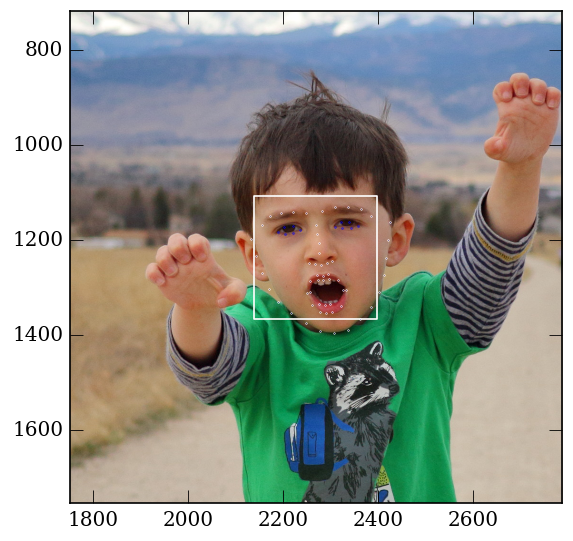

In [330]:
imshow(imgmp)
f1 = faces[index]
shape = fshapes[index]
dx = sqrt(f1.area())
fill_between([f1.left(),f1.right()],[f1.bottom(),f1.bottom()],[f1.top(),f1.top()],color='None',edgecolor='w')
for i, p in enumerate(shape.parts()):
    ec = 'w'
    if(( i > 35 ) & (i < 48)):
        ec = 'b'
    scatter(p.x,p.y,s=.1,edgecolor=ec)
#for (ex,ey,ew,eh) in eyes:
#    fill_between([x+ex,x+ex+ew],[y+ey,y+ey],[y+ey+eh,y+ey+eh],color='None',edgecolor='r')
#axis([1500,3000,2000,500])
axis([f1.center().x-2*dx,f1.center().x+2*dx,f1.center().y + 2 * dx, f1.center().y - 2*dx])
#axis([x-2.5*w,x+3.5*w,y+3.5*h,y-2.5*h])

In [331]:
#eyes are at 36 - 41 and 42 - 47


In [332]:
eyes = ([get_left_eye(shape),get_right_eye(shape)])

In [333]:
#calculate contrast inside face region
#We use a Laplacian filter to estimate the amount of contrast in the image following http://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
f1 = faces[index]
faceimg = gray[f1.top():f1.bottom(), f1.left():f1.right()]
lap_faceimg = cv2.Laplacian(faceimg, 8)
eyestd = []
per90 = []
per99 = []
eyeimgs = []
for (ex,ey,ew,eh) in array(eyes):
    print ex,ey,ew,eh
    eyeimg = gray[ey-20:ey+eh+20, ex-20:ex+ew+20]
    eyeimgs.append(eyeimg)
    lap_eyeimg = cv2.Laplacian(eyeimg, 8)
    eyestd.append( lap_eyeimg.std())
    per99.append(percentile(lap_eyeimg,99.9))
print "Face std", lap_faceimg.std(), " and eye stds ", eyestd, per99, percentile(lap_faceimg,99.9)

2308 1161 49 14
2188 1170 47 17
Face std 3.60088808872  and eye stds  [3.924774191575521, 4.3400856157429564] [27.390000000001237, 27.084000000000742] 35.0


Eye # 2  is most in focus


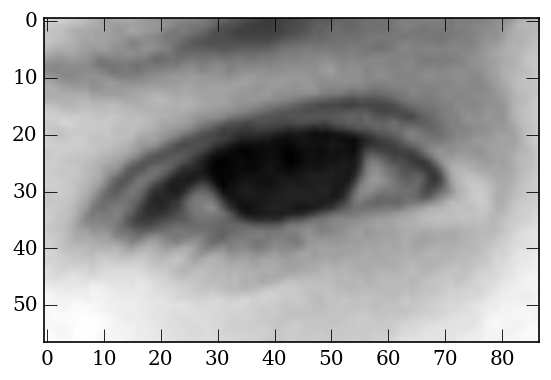

In [334]:
if( lap_faceimg.std() > max(eyestd) ):
    print "Face is Most in focus"
else:
    print "Eye #", argmax(eyestd) + 1, " is most in focus"
    imshow(eyeimgs[argmax(eyestd)],cmap='gray')
    